In [1]:
%load_ext autoreload
%autoreload 2
from demand_forecast import (
    df_hospital_inpatients, 
    df_population_history,
    df_population_projection,
    df_elderly_population,
    df_elderly_population_per_region,
    df_per_capita_demand,
    grid_search_ARIMA,
    forecast_ARIMA,
    forecast_demand,
    ProjectionVariant,
    REGION_CODE, YEAR, VALUE, REGION_CODE_MAPPING,
    DISTRICT_CODE
)


### Plotting trends of Hospital Inpatients, Population History and Per-Capita Demand

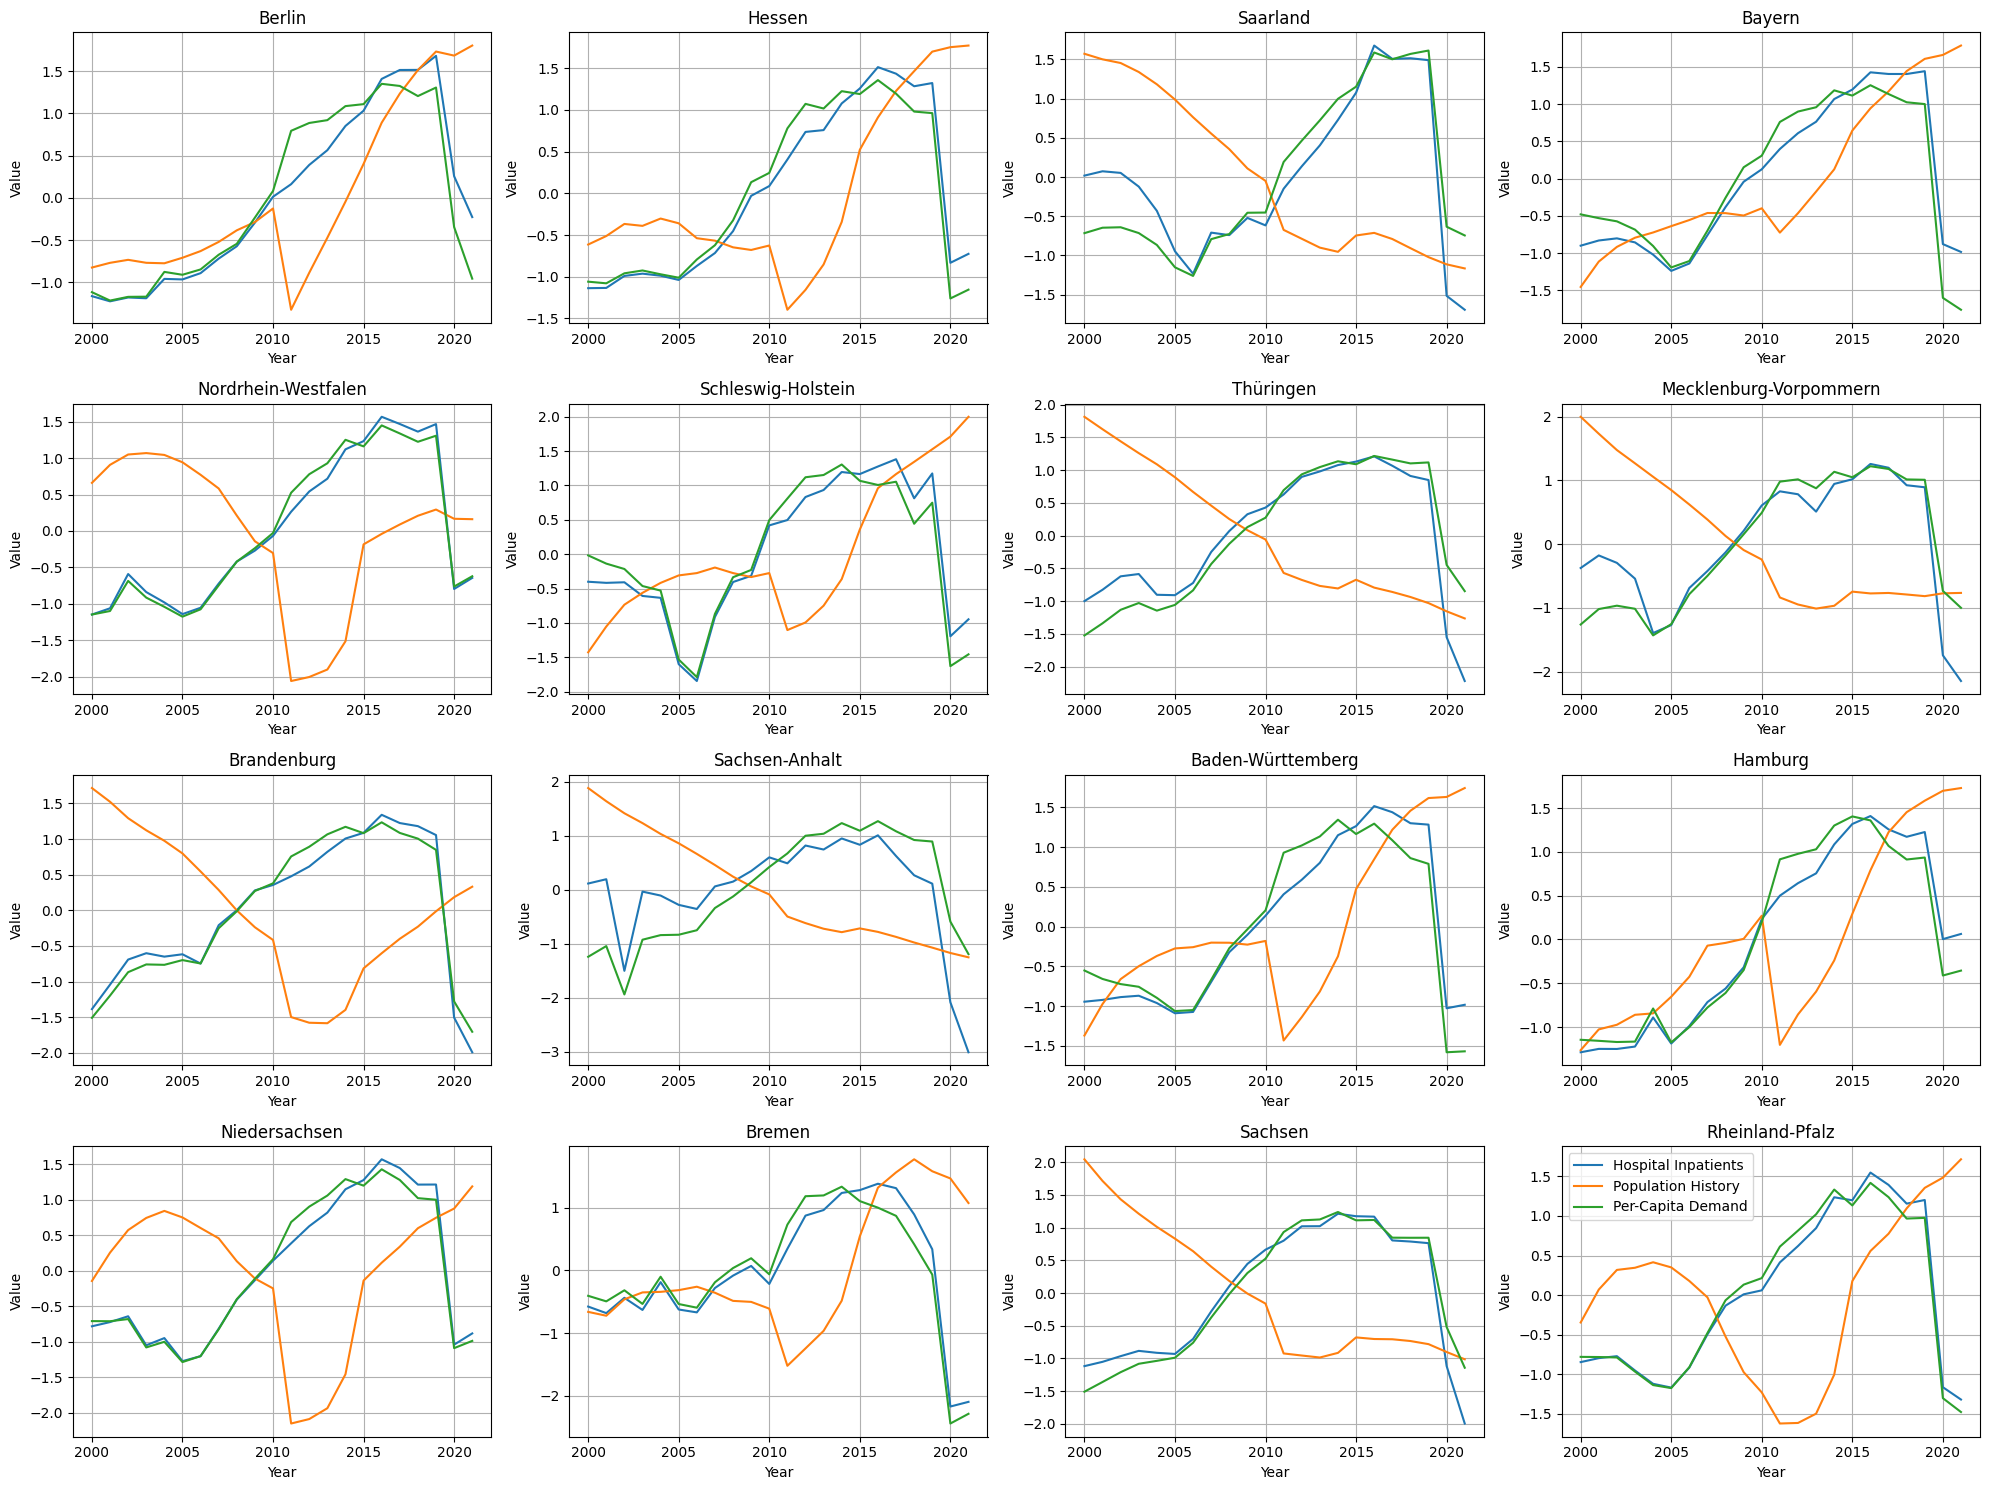

In [2]:
import matplotlib.pyplot as plt

dfph = df_population_history()
dfph = dfph.pivot(
    index=REGION_CODE,
    columns=YEAR,
    values=VALUE
)
dfhi = df_hospital_inpatients()
dfhi = dfhi.pivot(
    index=REGION_CODE,
    columns=YEAR,
    values=VALUE
)
dfpcd = df_per_capita_demand()

fig, axes = plt.subplots(4, 4, figsize=(20, 15))
axes = axes.flatten()
for i, code in enumerate(REGION_CODE_MAPPING.keys()):
    ax = axes[i]
    hi = (dfhi.loc[code] - dfhi.loc[code].mean()) / dfhi.loc[code].std()
    ph = (dfph.loc[code] - dfph.loc[code].mean()) / dfph.loc[code].std()
    pcd = (dfpcd.loc[code] - dfpcd.loc[code].mean()) / dfpcd.loc[code].std()
    hi.plot(kind="line", ax=ax, label='Hospital Inpatients')
    ph.plot(kind="line", ax=ax, label='Population History')
    pcd.plot(kind="line", ax=ax, label='Per-Capita Demand')
    ax.set_title(REGION_CODE_MAPPING[code])
    ax.set_xlabel('Year')
    ax.set_ylabel('Value')
    ax.grid(True)
   
ax.legend()
plt.tight_layout()
plt.show()

### Fitting and Forecasting with ARIMA Model 

In [ ]:
region_code = 10
per_capita_demand = dfpcd.loc[region_code]

best_model, best_order = grid_search_ARIMA(
    per_capita_demand, 
    p_values=[0,1,2,3], 
    d_values=[0,1,2,3], 
    q_values=[0,1,2,3]
)

In [4]:
period = 17
forecast, conf_int = forecast_ARIMA(best_model, period)

/home/mws/uni/Data Science/equity-aware-geospatial-ai-project/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/mws/uni/Data Science/equity-aware-geospatial-ai-project/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


/tmp/ipykernel_107572/3467358690.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


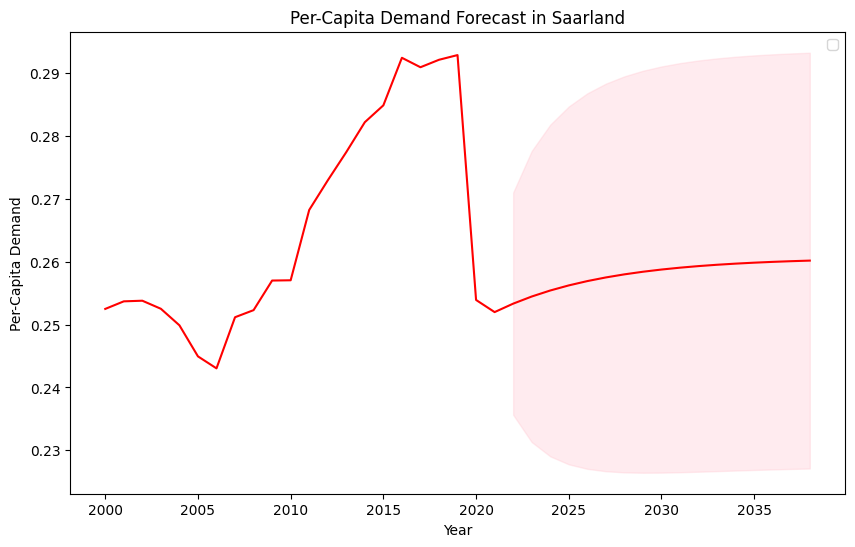

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Combine
full_series = pd.concat([per_capita_demand, forecast])

# Plot
plt.figure(figsize=(10, 6))
plt.plot(full_series.index, full_series.values, color='red')

# Add confidence intervals (only on forecast part)
plt.fill_between(forecast.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.title(f'Per-Capita Demand Forecast in {REGION_CODE_MAPPING[region_code]}')
plt.xlabel('Year')
plt.ylabel('Per-Capita Demand')
plt.legend()
plt.show()


### Forecasting Demand per Region-Level
For variant BEV-VARIANTE-01

In [7]:
demand, demand_conf_int = forecast_demand(forecast, region_code, ProjectionVariant.VAR01, conf_int)

/tmp/ipykernel_107572/1074339572.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


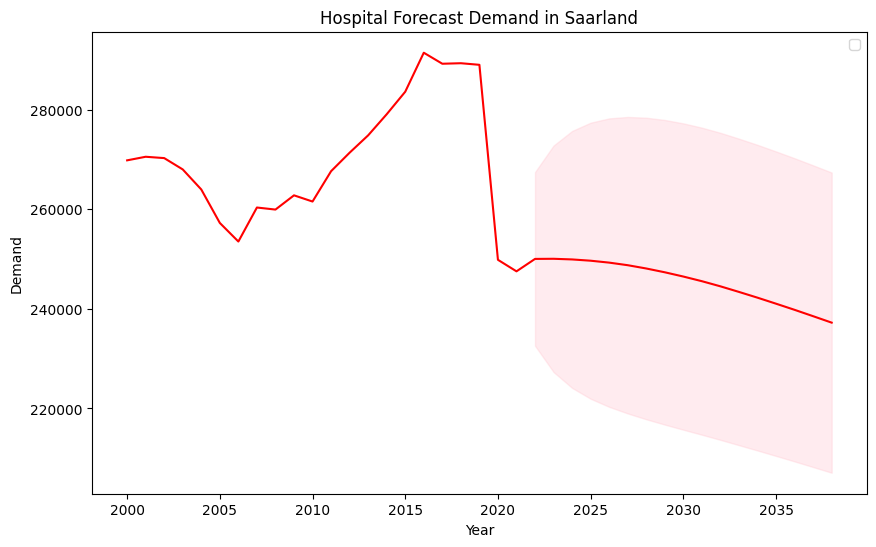

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

history_hospital_inpatients = dfhi.loc[region_code]

# Combine
full_series = pd.concat([history_hospital_inpatients, demand])

# Plot
plt.figure(figsize=(10, 6))
plt.plot(full_series.index, full_series.values, color='red')

# Add confidence intervals (only on forecast part)
plt.fill_between(forecast.index, demand_conf_int.iloc[:, 0], demand_conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.title(f'Hospital Forecast Demand in {REGION_CODE_MAPPING[region_code]}')
plt.xlabel('Year')
plt.ylabel('Demand')
plt.legend()
plt.show()

### Forecasting Elderly Population per District-Level

In [9]:
elderly_population = df_elderly_population_per_region(region_code)

In [ ]:
combined_dfs = []
for district_code in elderly_population.index:
    elderly_district_population = elderly_population.loc[district_code]
    best_model, best_order = grid_search_ARIMA(
        elderly_district_population, 
        p_values=[3], 
        d_values=[0], 
        q_values=[0]
    )
    elderly_forecast, _ = forecast_ARIMA(best_model, period)
    # turns year index into a column
    df_elderly_forecast = elderly_forecast.to_frame().rename(columns={'predicted_mean': VALUE})
    df_elderly_forecast[DISTRICT_CODE] = district_code
    combined_dfs.append(df_elderly_forecast)

final_df = pd.concat(combined_dfs)

    

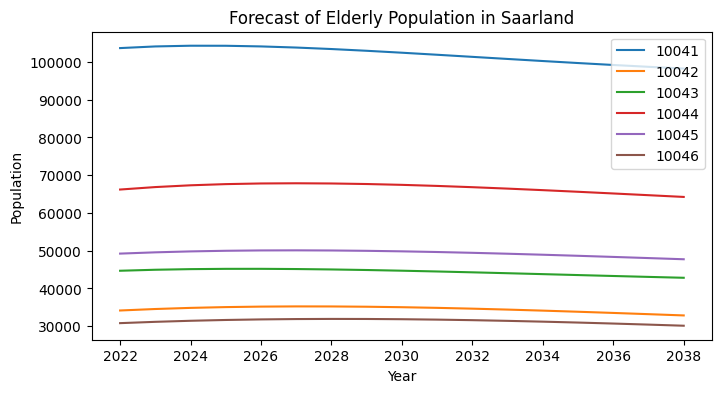

In [11]:
import matplotlib.pyplot as plt

plot_df = final_df.reset_index().rename(columns={'index': YEAR})
plot_df = plot_df.pivot(
    index=DISTRICT_CODE,
    columns=YEAR,
    values=VALUE
)

plt.figure(figsize=(8, 4))

for district_code in plot_df.index:
    plt.plot(plot_df.loc[district_code], label=district_code)

plt.title(f'Forecast of Elderly Population in {REGION_CODE_MAPPING[region_code]}')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()
plt.show()


### Forecasting Demand per District-Level

In [12]:
year = 2030
demand_per_district = final_df.loc[year]
demand_per_district[VALUE] = (demand_per_district[VALUE]/demand_per_district[VALUE].sum()) * demand[year]

/tmp/ipykernel_107572/127456465.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demand_per_district[VALUE] = (demand_per_district[VALUE]/demand_per_district[VALUE].sum()) * demand[year]


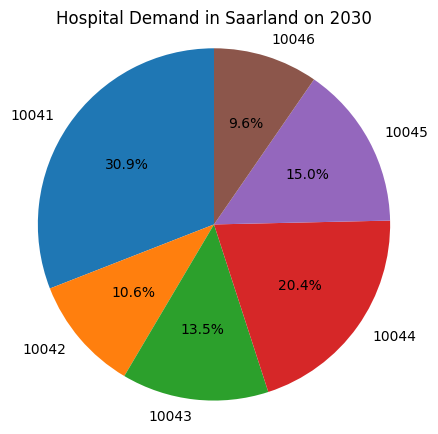

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.pie(demand_per_district[VALUE], labels=demand_per_district[DISTRICT_CODE], autopct='%1.1f%%', startangle=90)
plt.title(f'Hospital Demand in {REGION_CODE_MAPPING[region_code]} on {year}')
plt.axis('equal')  # Ensures pie is drawn as a circle
plt.show()
